In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/Project/Predict_Stock

/content/drive/MyDrive/Project/Predict_Stock


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [22]:
company = 'BBRI'
stock_data = pd.read_csv('/content/drive/MyDrive/Project/Predict_Stock/BBRI_2006-01-01_to_2022-03-16.csv', parse_dates=['Date'], sep=',', index_col='Date')

In [23]:
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2006-01-02,302.5,300.0,300.0,300.0,43290000.0,191.781586
2006-01-03,317.5,300.0,300.0,317.5,363975000.0,202.968842
2006-01-04,335.0,320.0,320.0,335.0,525260000.0,214.156067
2006-01-05,335.0,327.5,335.0,330.0,160810000.0,210.959717
2006-01-06,335.0,327.5,330.0,332.5,101620000.0,212.557907
...,...,...,...,...,...,...
2022-03-10,4640.0,4510.0,4640.0,4570.0,225575800.0,4395.767090
2022-03-11,4440.0,4370.0,4400.0,4400.0,275965300.0,4400.000000
2022-03-14,4400.0,4400.0,4400.0,4400.0,0.0,4400.000000


Text(0.5, 1.0, 'BBRI stock closing price')

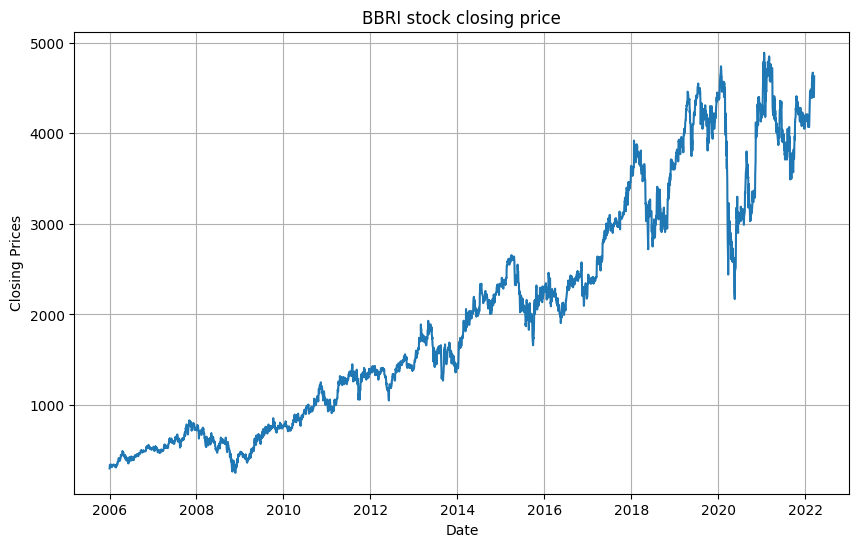

In [27]:
df_close = stock_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('BBRI stock closing price')

In [25]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

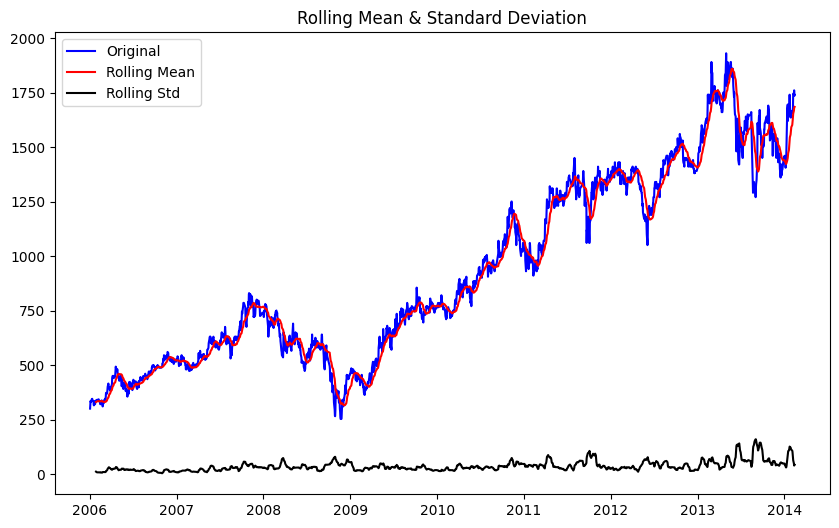

Results of Dickey-Fuller Test:
Test Statistic                   -0.606311
p-value                           0.869550
#Lags Used                       24.000000
Number of Observations Used    1975.000000
Critical Value (1%)              -3.433665
Critical Value (5%)              -2.863005
Critical Value (10%)             -2.567550
dtype: float64


In [26]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

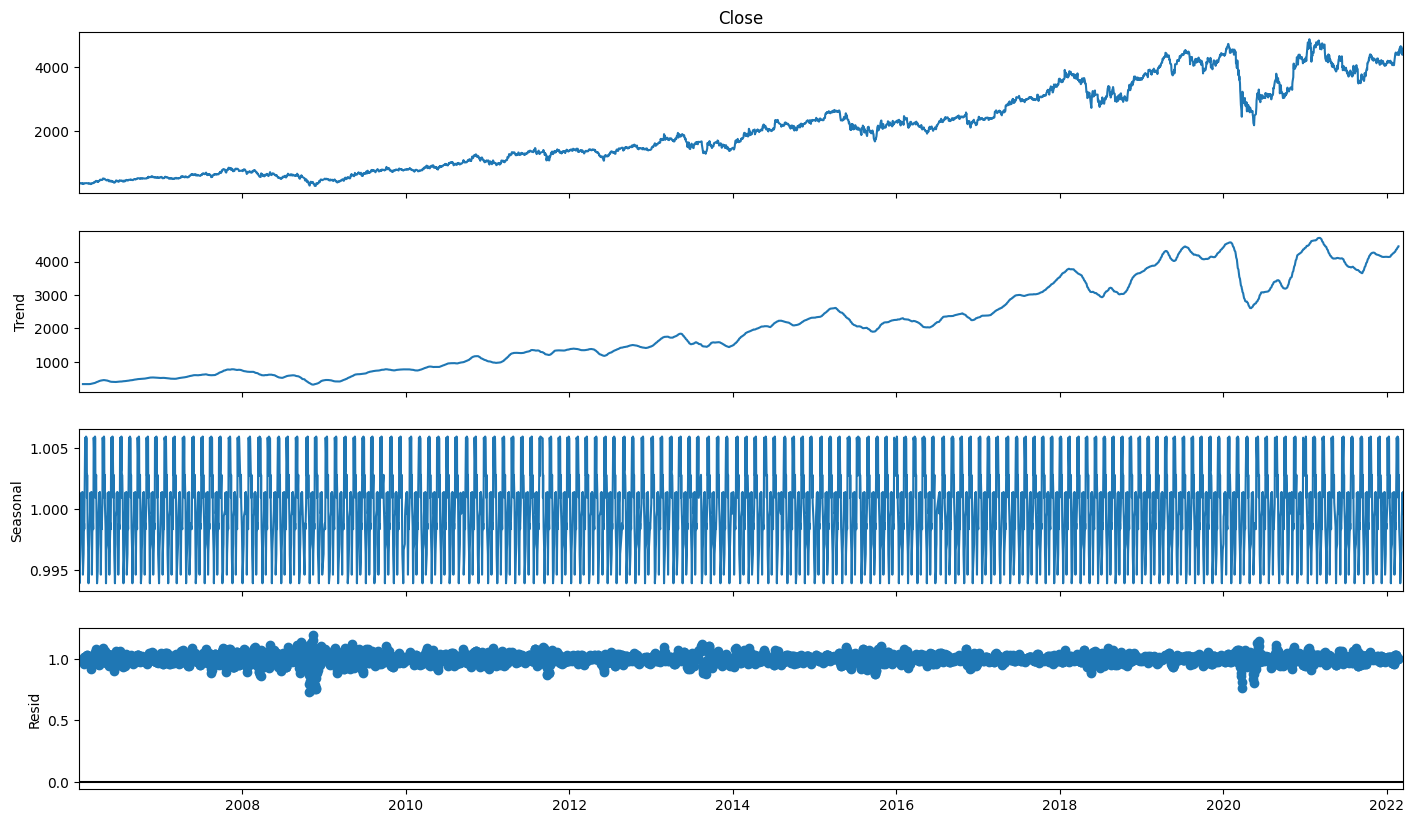

In [28]:
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

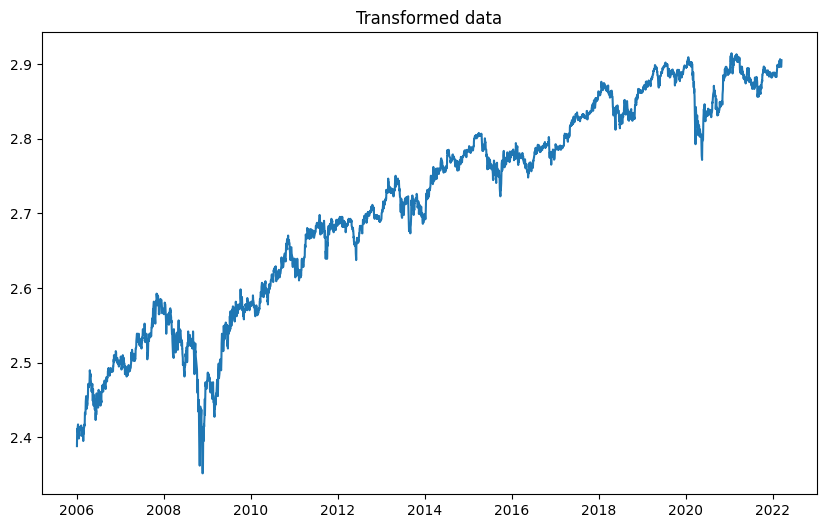

In [29]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

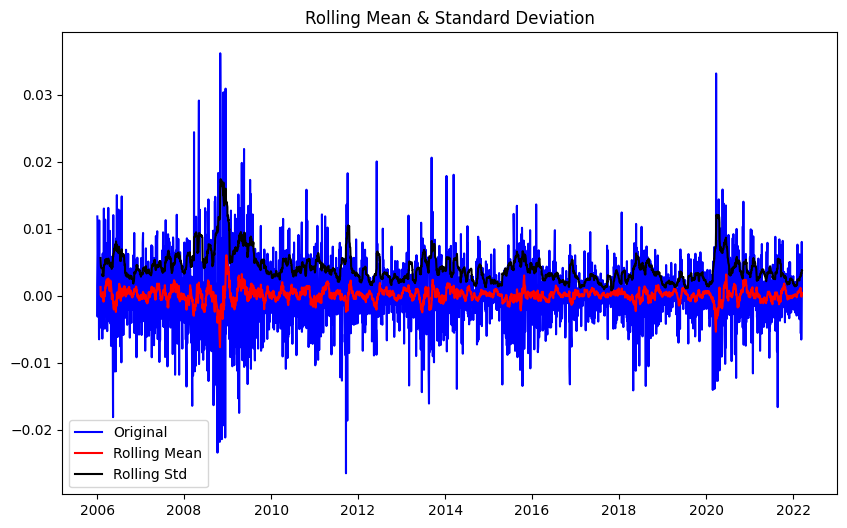

Results of Dickey-Fuller Test:
Test Statistic                -1.146265e+01
p-value                        5.506419e-21
#Lags Used                     2.600000e+01
Number of Observations Used    3.989000e+03
Critical Value (1%)           -3.431990e+00
Critical Value (5%)           -2.862265e+00
Critical Value (10%)          -2.567156e+00
dtype: float64


In [30]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [31]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [32]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [33]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

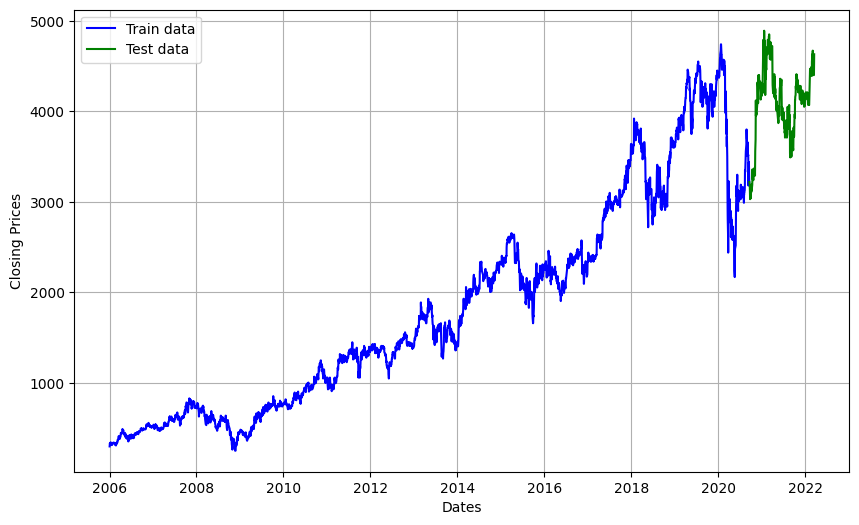

In [34]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [35]:
def vanilla_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

In [36]:
model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.8515e-05 - mean_absolute_error: 0.0039
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1780e-05 - mean_absolute_error: 0.0033
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4712e-05 - mean_absolute_error: 0.0034
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4962e-05 - mean_absolute_error: 0.0034
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2643e-05 - mean_absolute_error: 0.0033
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3202e-05 - mean_absolute_error: 0.0034
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4756e-05 - mean_absolute_error: 0.0033
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2025e-05 - mean_absolute_error: 0.0033
Epoch 9/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2561e-05 - mean_absolute_error: 0.0033
Epoch 10/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5422e-05 - mean_absolute_err

In [38]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3885e-05 - mean_absolute_error: 0.0029
Test MSE: 1.2123314263590146e-05
Test MAE: 0.002642665756866336


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


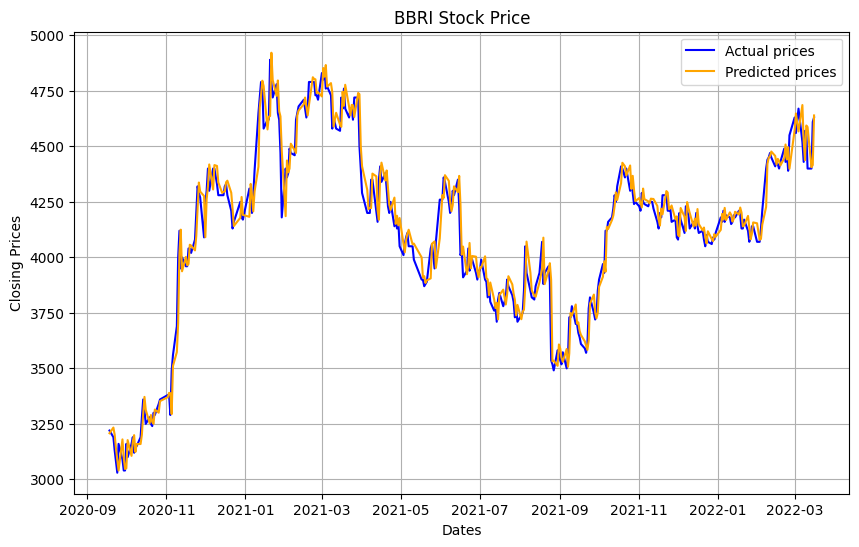

In [39]:
y_pred = model.predict(X_test)

pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

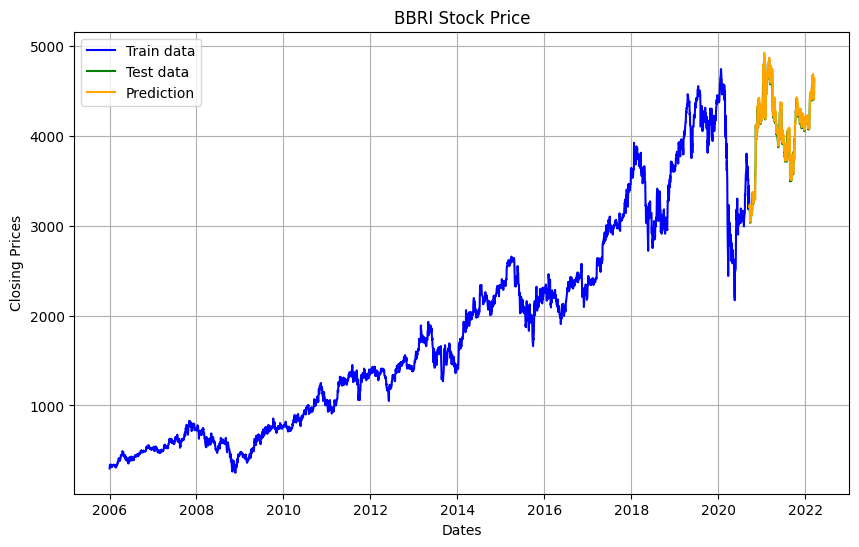

In [40]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'orange', label='Prediction')
plt.title(company + ' Stock Price')
plt.legend()

In [43]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

In [44]:
n_steps_out = 10

nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)

In [45]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [46]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [47]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,910 (42.62 KB)

 Trainable params: 10,910 (42.62 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.4794e-05 - mean_absolute_error: 0.0035
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3752e-05 - mean_absolute_error: 0.0034
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3689e-05 - mean_absolute_error: 0.0034
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2999e-05 - mean_absolute_error: 0.0033
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3818e-05 - mean_absolute_error: 0.0034
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4441e-05 - mean_absolute_error: 0.0034
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2379e-05 - mean_absolute_error: 0.0033
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4094e-05 - mean_absolute_error: 0.0034
Epoch 9/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3387e-05 - mean_absolute_error: 0.0033
Epoch 10/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3517e-05 - mean_absolute_err

In [49]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5168e-05 - mean_absolute_error: 0.0030  
Test MSE: 1.2710183000308461e-05
Test MAE: 0.002691017696633935


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

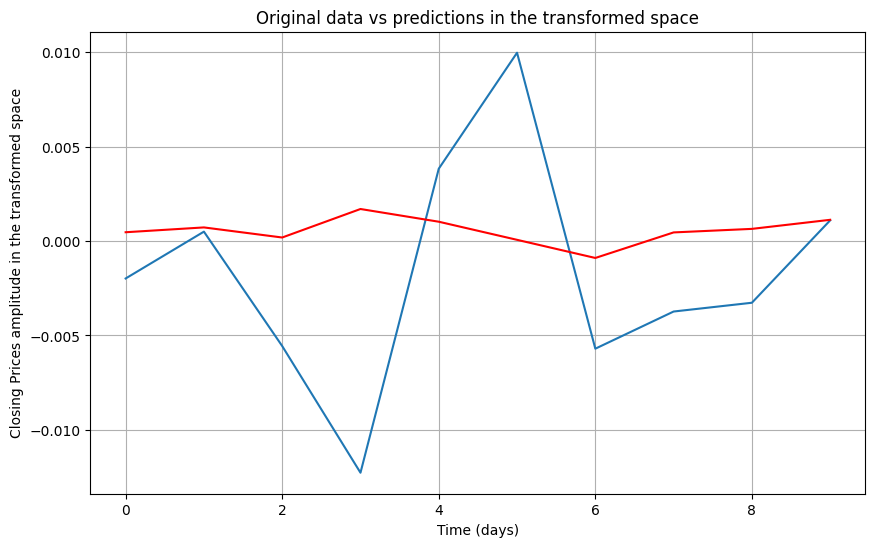

In [50]:
y_pred = model.predict(X_test)

the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [51]:
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2020-09-18    2.893736
2020-09-21    2.894458
2020-09-22    2.894645
2020-09-23    2.896342
2020-09-24    2.897365
2020-09-25    2.897430
2020-09-28    2.896533
2020-09-29    2.896990
2020-09-30    2.897634
2020-10-01    2.898759
dtype: float64


In [52]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2020-09-18    4331.673744
2020-09-21    4349.798568
2020-09-22    4354.519173
2020-09-23    4397.512251
2020-09-24    4423.664430
2020-09-25    4425.320097
2020-09-28    4402.403184
2020-09-29    4414.068159
2020-09-30    4430.577182
2020-10-01    4459.554532
dtype: float64


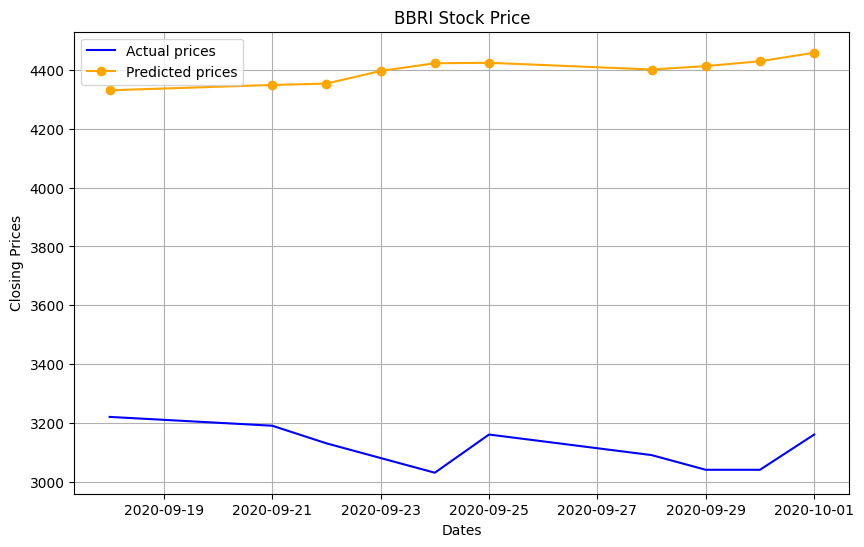

In [53]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()